In [1]:
# Import all the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers

# load the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = df_train.append(df_test , ignore_index = True)



# some quick inspections
df_train.shape, df_test.shape, df_train.columns.values, df_test.columns.values

((891, 12),
 (418, 11),
 array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object),
 array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object))

In [2]:
# inspect the correlation between Pclass and Survived
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [3]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

# inspect the amount of people for each title
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Sir               1
Jonkheer          1
Don               1
the Countess      1
Dona              1
Mme               1
Capt              1
Lady              1
Name: Title, dtype: int64

In [4]:
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df.Title.loc[ (df.Title !=  'Master') & (df.Title !=  'Mr') & (df.Title !=  'Miss') 
             & (df.Title !=  'Mrs')] = 'Others'

# inspect the correlation between Title and Survived
df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

S:\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.796875
4,Others,0.318182


In [5]:
# inspect the amount of people for each title
df['Title'].value_counts()

Mr        757
Miss      262
Mrs       201
Master     61
Others     28
Name: Title, dtype: int64

In [6]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

In [7]:
# check if there is any NAN
df.Sex.isnull().sum(axis=0)

0

In [8]:
# inspect the correlation between Sex and Survived
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [9]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

In [10]:
# check if there is any NAN
df.Age.isnull().sum(axis=0)

263

In [11]:
# check if there is any NAN
df.SibSp.isnull().sum(axis=0), df.Parch.isnull().sum(axis=0)

(0, 0)

In [12]:
# create a new feature "Family"
df['Family'] = df['SibSp'] + df['Parch'] + 1

# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [13]:
# inspect the amount of people for each Family size
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [14]:
df.Family = df.Family.map(lambda x: 0 if x > 4 else x)
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,0,0.161290
1,1,0.303538
2,2,0.552795
3,3,0.578431
4,4,0.724138


In [15]:
df['Family'].value_counts()

1    790
2    235
3    159
0     82
4     43
Name: Family, dtype: int64

In [16]:
# check if there is any NAN
df.Ticket.isnull().sum(axis=0)

0

In [17]:
df.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [18]:
df.Ticket = df.Ticket.map(lambda x: x[0])

# inspect the correlation between Ticket and Survived
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [19]:
# inspect the amount of people for each type of tickets
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

In [20]:
df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Fare
0,1,65.771211
1,2,20.235194
2,3,15.380682
3,4,16.764036
4,5,19.262500
5,6,19.153711
6,7,9.197438
7,8,8.397900
8,9,7.750000
9,A,10.189681


In [21]:
df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Pclass
0,1,1.147619
1,2,2.309353
2,3,2.904429
3,4,3.000000
4,5,2.333333
5,6,2.111111
6,7,3.000000
7,8,3.000000
8,9,3.000000
9,A,3.000000


In [22]:
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

1

In [23]:
df.Ticket[df.Fare.isnull()]

1043    3
Name: Ticket, dtype: object

In [24]:
df.Pclass[df.Fare.isnull()]

1043    3
Name: Pclass, dtype: int64

In [25]:
df.Cabin[df.Fare.isnull()]

1043    NaN
Name: Cabin, dtype: object

In [26]:
df.Embarked[df.Fare.isnull()]

1043    S
Name: Embarked, dtype: object

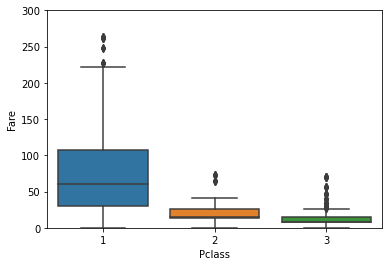

In [27]:
# use boxplot to visualize the distribution of Fare for each Pclass
sns.boxplot('Pclass','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [28]:
# inspect the correlation between Pclass and Fare
df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,87.508992
2,21.179196
3,13.302889


In [29]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Pclass
df[['Pclass', 'Fare']].groupby(['Pclass']).std() / df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,0.919302
2,0.642476
3,0.864050


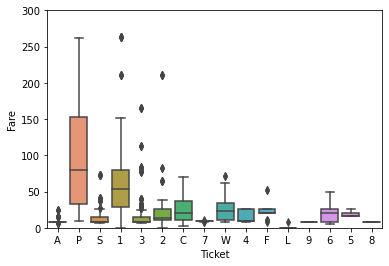

In [30]:
# use boxplot to visualize the distribution of Fare for each Ticket
sns.boxplot('Ticket','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [31]:
# inspect the correlation between Ticket and Fare 
# (we saw this earlier)
df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,65.771211
2,20.235194
3,15.380682
4,16.764036
5,19.262500
6,19.153711
7,9.197438
8,8.397900
9,7.750000


In [32]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Ticket type
df[['Ticket', 'Fare']].groupby(['Ticket']).std() /  df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,0.817411
2,1.284139
3,1.351244
4,0.497578
5,0.284367
6,0.735873
7,0.080078
8,0.005961
9,0.000000


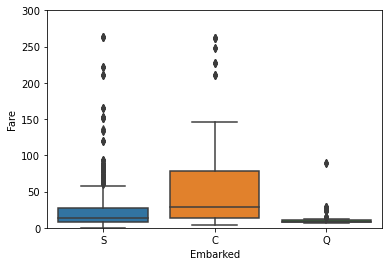

In [33]:
# use boxplot to visualize the distribution of Fare for each Embarked
sns.boxplot('Embarked','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [34]:
# inspect the correlation between Embarked and Fare
df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,62.336267
Q,12.409012
S,27.418824


In [35]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Embarked
df[['Embarked', 'Fare']].groupby(['Embarked']).std() /  df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,1.350514
Q,1.097278
S,1.352954


In [36]:
guess_Fare = df.Fare.loc[ (df.Ticket == '3') & (df.Pclass == 3) & (df.Embarked == 'S')].median()
df.Fare.fillna(guess_Fare , inplace=True)

# inspect the mean Fare values for people who died and survived
df[['Fare', 'Survived']].groupby(['Survived'],as_index=False).mean()

,Survived,Fare
0,0.0,22.117887
1,1.0,48.395408


S:\Anaconda\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


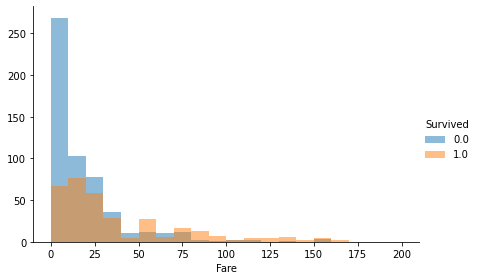

In [37]:
# visualize the distribution of Fare for people who survived and died
grid = sns.FacetGrid(df, hue='Survived', size=4, aspect=1.5)
grid.map(plt.hist, 'Fare', alpha=.5, bins=range(0,210,10))
grid.add_legend()
plt.show()

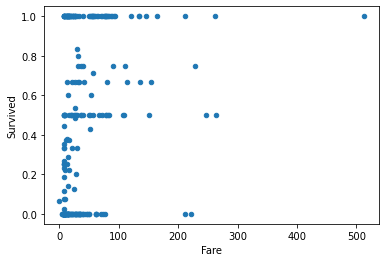

In [38]:
# visualize the correlation between Fare and Survived using a scatter plot
df[['Fare', 'Survived']].groupby(['Fare'],as_index=False).mean().plot.scatter('Fare','Survived')
plt.show()

In [39]:
# bin Fare into five intervals with equal amount of people
df['Fare-bin'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

# inspect the correlation between Fare-bin and Survived
df[['Fare-bin', 'Survived']].groupby(['Fare-bin'], as_index=False).mean()

,Fare-bin,Survived
0,1,0.217877
1,2,0.201087
2,3,0.426901
3,4,0.443243
4,5,0.645349


In [40]:
# check if there is any NAN
df.Cabin.isnull().sum(axis=0)

1014

In [41]:
df = df.drop(labels=['Cabin'], axis=1)

In [42]:
# check if there is any NAN
df.Embarked.isnull().sum(axis=0)

2

In [43]:
df.describe(include=['O']) # S is the most common

,Ticket,Embarked,Title
count,1309,1307,1309
unique,16,3,5
top,3,S,Mr
freq,429,914,757


In [44]:
# fill the NAN
df.Embarked.fillna('S' , inplace=True )

In [45]:
# inspect the correlation between Embarked and Survived as well as some other features
df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived,Pclass,Fare,Age,Sex
0,C,0.553571,1.851852,62.336267,32.332170,0.418519
1,Q,0.389610,2.894309,12.409012,28.630000,0.487805
2,S,0.339009,2.344978,27.512485,29.298151,0.319869


In [46]:
df = df.drop(labels='Embarked', axis=1)

S:\Anaconda\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


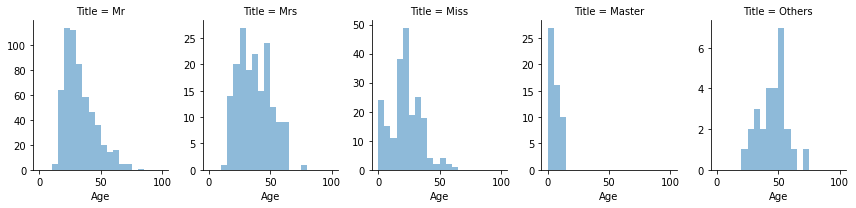

In [47]:
# visualize the correlation between Title and Age
grid = sns.FacetGrid(df, col='Title', size=3, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [48]:
# inspect the mean Age for each Title
df[['Title', 'Age']].groupby(['Title']).mean()

,Age
Title,
Master,5.482642
Miss,21.795236
Mr,32.252151
Mrs,36.930636
Others,45.074074


In [49]:
df[['Title', 'Age']].groupby(['Title']).std()

,Age
Title,
Master,4.161554
Miss,12.192794
Mr,12.422089
Mrs,12.872625
Others,11.303253


S:\Anaconda\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


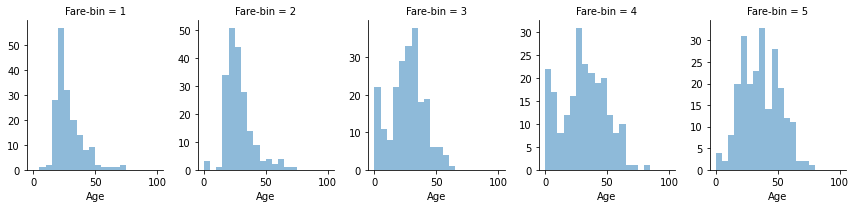

In [50]:
# visualize the correlation between Fare-bin and Age
grid = sns.FacetGrid(df, col='Fare-bin', size=3, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [51]:
# inspect the mean Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).mean()

,Age
Fare-bin,
1,27.848315
2,27.898241
3,26.144009
4,30.728604
5,35.877913


In [52]:
# inspect the standard deviation of Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).std()

,Age
Fare-bin,
1,10.812580
2,10.995650
3,13.523208
4,17.466022
5,15.150724


S:\Anaconda\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


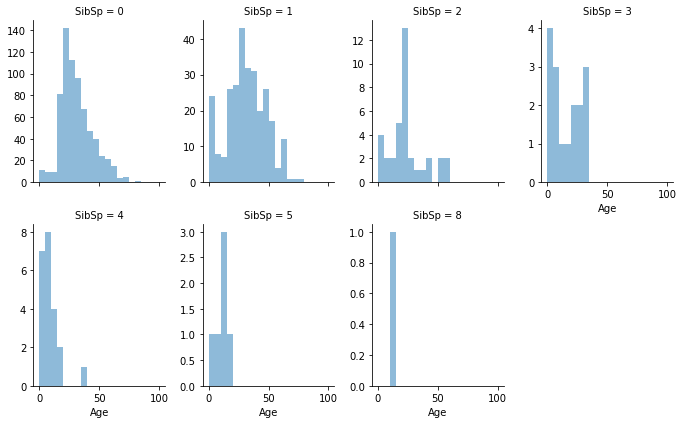

In [53]:
# visualize the correlation between SibSp and Age
grid = sns.FacetGrid(df, col='SibSp', col_wrap=4, size=3.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [54]:
# inspect the mean Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).mean()

,Age
SibSp,
0,30.921766
1,31.058071
2,23.569444
3,16.312500
4,8.772727
5,10.166667
8,14.500000


In [55]:
# inspect the standard deviation of Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).std()

,Age
SibSp,
0,13.059751
1,15.974482
2,14.910640
3,11.824938
4,8.005545
5,5.192944
8,NaN


S:\Anaconda\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


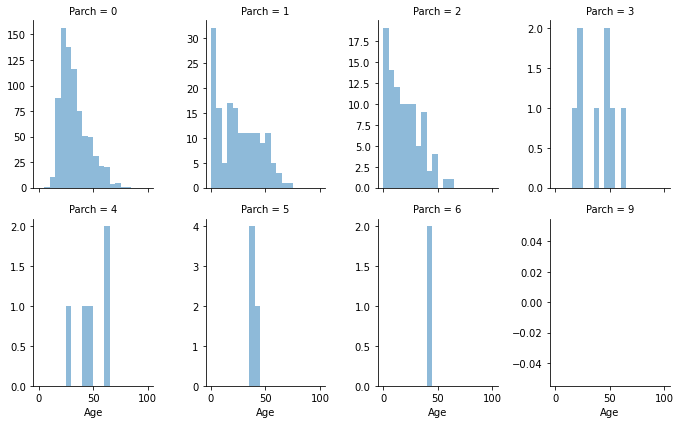

In [56]:
# visualize the correlation between Parch and Age
grid = sns.FacetGrid(df, col='Parch', col_wrap=4, size=3.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [57]:
# inspect the mean Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).mean()

,Age
Parch,
0,31.969401
1,24.965625
2,18.975979
3,38.875000
4,47.600000
5,39.333333
6,41.500000
9,NaN


In [58]:
# inspect the standard deviation of Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).std() 

,Age
Parch,
0,12.422617
1,18.410885
2,14.564066
3,16.295815
4,14.432602
5,1.032796
6,2.121320
9,NaN


In [59]:
# notice that instead of using Title, we should use its corresponding dummy variables 
df_sub = df[['Age','Master','Miss','Mr','Mrs','Others','Fare-bin','SibSp']]

X_train  = df_sub.dropna().drop('Age', axis=1)
y_train  = df['Age'].dropna()
X_test = df_sub.loc[np.isnan(df.Age)].drop('Age', axis=1)

regressor = RandomForestRegressor(n_estimators = 300)
regressor.fit(X_train, y_train)
y_pred = np.round(regressor.predict(X_test),1)
df.Age.loc[df.Age.isnull()] = y_pred

df.Age.isnull().sum(axis=0) # no more NAN now

S:\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0

In [60]:
bins = [ 0, 4, 12, 18, 30, 50, 65, 100] # This is somewhat arbitrary...
age_index = (1,2,3,4,5,6,7)
#('baby','child','teenager','young','mid-age','over-50','senior')
df['Age-bin'] = pd.cut(df.Age, bins, labels=age_index).astype(int)

df[['Age-bin', 'Survived']].groupby(['Age-bin'],as_index=False).mean()

,Age-bin,Survived
0,1,0.675000
1,2,0.452381
2,3,0.402597
3,4,0.315789
4,5,0.427083
5,6,0.375000
6,7,0.125000


In [61]:
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [62]:
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

In [63]:
df['Ticket'] = df['Ticket'].replace(['A','W','F','L','5','6','7','8','9'], '4')

# check the correlation again
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.166667
4,C,0.340426
5,P,0.646154
6,S,0.323077


In [64]:
# dummy encoding
df = pd.get_dummies(df,columns=['Ticket'])

In [65]:
from sklearn.model_selection import train_test_split

df_RF = df[0:891].drop(labels=['SibSp','Parch','Age','Fare','Title'], axis=1)

predictors = df_RF.drop(['Survived', 'PassengerId'], axis=1)
target = df_RF["Survived"]

x_Rtrain, x_Rval, y_Rtrain, y_Rval = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [66]:
df = df.drop(labels=['SibSp','Parch','Age','Fare','Title'], axis=1)

y_train = df[0:891]['Survived'].values
X_train = df[0:891].drop(['Survived','PassengerId'], axis=1).values
X_test  = df[891:].drop(['Survived','PassengerId'], axis=1).values

In [67]:
#Sequential?

In [68]:
df

,PassengerId,Survived,Pclass,Sex,Master,Miss,Mr,Mrs,Others,Family,Fare-bin,Age-bin,Ticket_1,Ticket_2,Ticket_3,Ticket_4,Ticket_C,Ticket_P,Ticket_S
0,1,0.0,3,0,0,0,1,0,0,2,1,4,0,0,0,1,0,0,0
1,2,1.0,1,1,0,0,0,1,0,2,5,5,0,0,0,0,0,1,0
2,3,1.0,3,1,0,1,0,0,0,1,2,4,0,0,0,0,0,0,1
3,4,1.0,1,1,0,0,0,1,0,2,5,5,1,0,0,0,0,0,0
4,5,0.0,3,0,0,0,1,0,0,1,2,5,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,0,0,0,1,0,0,1,2,4,0,0,0,1,0,0,0
1305,1306,NaN,1,1,0,0,0,0,1,1,5,5,0,0,0,0,0,1,0
1306,1307,NaN,3,0,0,0,1,0,0,1,1,5,0,0,0,0,0,0,1
1307,1308,NaN,3,0,0,0,1,0,0,1,2,4,0,0,1,0,0,0,0


In [69]:
display(df.iloc[19]) 

PassengerId    20.0
Survived        1.0
Pclass          3.0
Sex             1.0
Master          0.0
Miss            0.0
Mr              0.0
Mrs             1.0
Others          0.0
Family          1.0
Fare-bin        1.0
Age-bin         5.0
Ticket_1        0.0
Ticket_2        1.0
Ticket_3        0.0
Ticket_4        0.0
Ticket_C        0.0
Ticket_P        0.0
Ticket_S        0.0
Name: 19, dtype: float64

In [70]:
X_train.shape

(891, 17)

In [71]:
model = Sequential()

initializer = 'uniform'

model.add(Dense(units = 9, kernel_initializer = initializer, activation = 'relu', input_dim = 17))
model.add(Dense(units = 7, kernel_initializer = initializer, activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = initializer, activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = initializer, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 162       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 70        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 278
Trainable params: 278
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Train the ANN
history = model.fit(X_train, y_train, validation_split=0.20, batch_size = 30, epochs = 200)

Epoch 1/200
24/24 [==============================] - 2s 43ms/step - loss: 0.6898 - accuracy: 0.5930 - val_loss: 0.6745 - val_accuracy: 0.6425
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6670 - accuracy: 0.6126 - val_loss: 0.5724 - val_accuracy: 0.6425
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.6239 - val_loss: 0.4995 - val_accuracy: 0.7989
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.5399 - accuracy: 0.7963 - val_loss: 0.4221 - val_accuracy: 0.8268
Epoch 5/200
24/24 [==============================] - 0s 4ms/step - loss: 0.4700 - accuracy: 0.8021 - val_loss: 0.3811 - val_accuracy: 0.8492
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.8194 - val_loss: 0.3910 - val_accuracy: 0.8268
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4417 - accuracy: 0.8141 - val_loss: 0.3795 - val_accuracy: 0.8492
Epoch 8/200


Epoch 59/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3707 - accuracy: 0.8578 - val_loss: 0.3579 - val_accuracy: 0.8436
Epoch 60/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3960 - accuracy: 0.8278 - val_loss: 0.3629 - val_accuracy: 0.8436
Epoch 61/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4084 - accuracy: 0.8430 - val_loss: 0.3571 - val_accuracy: 0.8603
Epoch 62/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8434 - val_loss: 0.3601 - val_accuracy: 0.8603
Epoch 63/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8347 - val_loss: 0.3608 - val_accuracy: 0.8603
Epoch 64/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.8274 - val_loss: 0.3566 - val_accuracy: 0.8547
Epoch 65/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.8208 - val_loss: 0.3562 - val_accuracy: 0.8603
Epoch 

24/24 [==============================] - 0s 3ms/step - loss: 0.4062 - accuracy: 0.8320 - val_loss: 0.3555 - val_accuracy: 0.8436
Epoch 117/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy: 0.8211 - val_loss: 0.3541 - val_accuracy: 0.8492
Epoch 118/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3903 - accuracy: 0.8238 - val_loss: 0.3522 - val_accuracy: 0.8492
Epoch 119/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4183 - accuracy: 0.8135 - val_loss: 0.3542 - val_accuracy: 0.8436
Epoch 120/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3855 - accuracy: 0.8291 - val_loss: 0.3504 - val_accuracy: 0.8492
Epoch 121/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4122 - accuracy: 0.8388 - val_loss: 0.3474 - val_accuracy: 0.8547
Epoch 122/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3996 - accuracy: 0.8263 - val_loss: 0.3572 - val_accuracy: 0.8547
Epoch 123/200

24/24 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.8150 - val_loss: 0.3367 - val_accuracy: 0.8603
Epoch 174/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3913 - accuracy: 0.8269 - val_loss: 0.3358 - val_accuracy: 0.8436
Epoch 175/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3735 - accuracy: 0.8344 - val_loss: 0.3419 - val_accuracy: 0.8547
Epoch 176/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4041 - accuracy: 0.8245 - val_loss: 0.3398 - val_accuracy: 0.8603
Epoch 177/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3681 - accuracy: 0.8473 - val_loss: 0.3366 - val_accuracy: 0.8492
Epoch 178/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.8250 - val_loss: 0.3360 - val_accuracy: 0.8547
Epoch 179/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.8326 - val_loss: 0.3442 - val_accuracy: 0.8659
Epoch 180/200

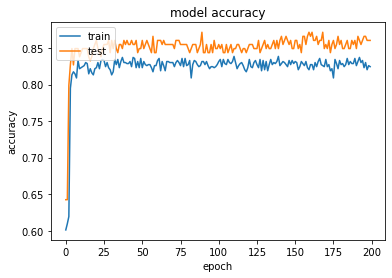

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

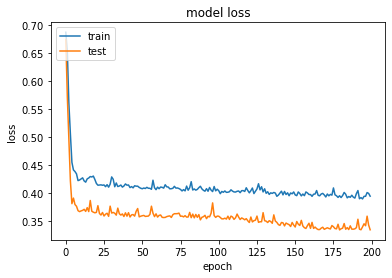

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


randomforest = RandomForestClassifier()
randomforest.fit(x_Rtrain, y_Rtrain)
y_pred = randomforest.predict(x_Rval)
acc_randomforest = round(accuracy_score(y_pred, y_Rval) * 100, 2)
print(acc_randomforest)

85.28


In [76]:
#y_pred = randomforest.predict(X_test)

#output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
#output.to_csv('prediction_RF_new.csv', index=False)

In [77]:
#y_pred = model.predict(X_test)
#y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])

#output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_final})
#output.to_csv('prediction_new.csv', index=False)

In [78]:
df_result = pd.read_csv('submission.csv')

In [79]:
df_result_analysis = pd.concat([df_test,df_result['Survived'] ], axis=1)

In [80]:
df_result_analysis

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [81]:
df_result_analysis.Sex = df_result_analysis.Sex.map({'male':0, 'female':1})

In [82]:
df_survived = df_result_analysis[df_result_analysis['Survived'] == 1]  
df_survived.count()

PassengerId    152
Pclass         152
Name           152
Sex            152
Age            131
SibSp          152
Parch          152
Ticket         152
Fare           152
Cabin           50
Embarked       152
Survived       152
dtype: int64

In [83]:
df_survived['Sex'].value_counts()

1    127
0     25
Name: Sex, dtype: int64

In [84]:
df_survived[df_survived['Age'] < 18.0 ].count() 

PassengerId    27
Pclass         27
Name           27
Sex            27
Age            27
SibSp          27
Parch          27
Ticket         27
Fare           27
Cabin           4
Embarked       27
Survived       27
dtype: int64

In [85]:
df_survived['Family'] = df_survived['SibSp'] + df_survived['Parch']
df_survived[df_survived['Family'] < 1.0 ].count() 

<ipython-input-85-b5835da4bfe3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survived['Family'] = df_survived['SibSp'] + df_survived['Parch']


PassengerId    64
Pclass         64
Name           64
Sex            64
Age            48
SibSp          64
Parch          64
Ticket         64
Fare           64
Cabin          11
Embarked       64
Survived       64
Family         64
dtype: int64

In [86]:
df_result_analysis.Ticket = df_result_analysis.Ticket.map(lambda x: x[0])

In [87]:
df_result_analysis['Ticket'].value_counts()

3    128
2     95
1     64
P     33
S     33
C     30
A     13
W      6
F      6
7      4
6      3
L      1
9      1
4      1
Name: Ticket, dtype: int64

In [88]:
df_result_analysis[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.531250
1,2,0.305263
2,3,0.296875
3,4,0.000000
4,6,0.000000
5,7,0.250000
6,9,0.000000
7,A,0.384615
8,C,0.333333
9,F,0.666667


In [89]:
df_result_analysis['Embarked'].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [90]:
df_result_analysis[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.460784
1,Q,0.434783
2,S,0.314815
